In [1]:
import sys
sys.path.insert(0, '../')
import src

In [2]:
# standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as scs

# import custom scripts
from src.plot import *
from src.data import *
from src.stats import *

%matplotlib inline
plt.style.use('ggplot')
%autoreload

UsageError: Line magic function `%autoreload` not found.


# The Math Behind AB Testing

## Outline
1. Set up the experiment
  * What is the goal? 
  * What is the metric and how much of an increase is worth the change? 
  * How much statistical power and level of significance do you need? Typically 80% and 0.05 are used respectively.
2. Set up a control group and test group by selecting users at random
3. Run the test -> Record the success rate for each group
4. Plot the distribution of the difference between the two samples
5. Measure the probability of getting the result of the test group and the confidence interval. Check to see if there is enough statistical power and that the level of significance is achieved.
6. Consider other tradeoffs and decide if the change should be launched

## Set up the experiment

The goal of running an AB test is to evaluate if a change in a website will lead to improved performance in a specific metric. You may decide to test very simple alternatives such as changing the look of a single button on a webpage or testing different layouts and headlines. You could also run an AB test on multi-step processes which may have many differences. Examples include signing up a new user or processing the sale on an online marketplace. There are many articles on the web about AB testing but very few actually get into the math. So, the goal of this article is to provide a walkthrough of a typical AB test with equations and plots at each step.

## Variables

* Sample size
* Baseline conversion rate
* Minimum detectable effect
* Desired statistical power
* Confidence level or level of significance

## Control Group A and Test Group B
Typically, users are randomly selected and assigned to either a control group or a test group, and the total number of users participating in the A/B test make up a small percentage of the total amount of users. For this article, we will run an A/B test for a hypothetical company that is trying to get users to sign up for a premium account.

Initially, we will collect 1000 samples for each group and serve the current signup page to the control group and a new signup page to the test group.

## Run the Test

Since this is just a hypothetical case, let's generate some fake data. In real-world applications, you will have to wait the amount of time needed to gather the data.

In [3]:
# A is control; B is test
N_A = 1000
N_B = 1000

You will also not be able to set the difference, `d_hat`, prior to your experiment, like we will be doing below for our hypothetical test.

In [4]:
# bcr: baseline conversion rate
# d_hat: difference in a metric between the two groups, sometimes referred to as minimal detectable effect or lift depending on the context
p_A = 0.10
p_B = 0.12

In [5]:
ab_data = generate_data(N_A, N_B, p_A, p_B)

In [6]:
ab_data.head(5)

,group,converted
0,A,0
1,B,0
2,A,0
3,B,0
4,B,0


Let's look at some of the metrics that are immediately available. First, let's confirm the amount of rows of data.

In [7]:
ab_data.shape

(2000, 2)

Next, let's see how many users from each group converted.

In [8]:
A_group = ab_data[ab_data['group'] == 'A']
B_group = ab_data[ab_data['group'] == 'B']

In [9]:
A_converted, B_converted = A_group['converted'].sum(), B_group['converted'].sum()
A_converted, B_converted

(104, 104)

In [10]:
A_total, B_total = len(A_group), len(B_group)
A_total, B_total

(960, 1040)

In [11]:
p_A, p_B = A_converted / A_total, B_converted / B_total
p_A, p_B

(0.10833333333333334, 0.1)

In [12]:
p_B - p_A

-0.008333333333333331

In [13]:
ab_summary = ab_data.pivot_table(values='converted', index='group', aggfunc=np.sum)
ab_summary['total'] = ab_data.pivot_table(values='converted', index='group', aggfunc=lambda x: len(x))
ab_summary['rate'] = ab_data.pivot_table(values='converted', index='group')

In [14]:
ab_summary

,converted,total,rate
group,,,
A,104,960,0.108333
B,104,1040,0.100000


The above result matches our parameters that we used to set up the test. Keep in mind that you will not be able to set how much lift you would see in the test group in real-world applications. However, you do have to decide how many samples you will need for the test and you will probably know the baseline conversion rate.

If you observe the conversion rate for both groups, you find that the new signup page resulted in an improvement of 2%. This is good news, but how can you demonstrate that this result is statistically significant.

## Compare the Two Samples

In [15]:
p_B * A_total

96.0

Text(0, 0.5, 'probability')

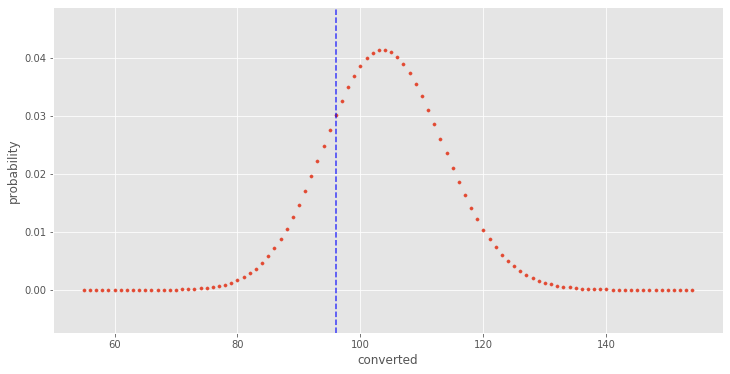

In [16]:
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(A_converted-49, A_converted+50, 100)
y = scs.binom(A_total, p_A).pmf(x)
ax.scatter(x, y, s=10)
ax.axvline(x=p_B * A_total, c='blue', alpha=0.75, linestyle='--')
plt.xlabel('converted')
plt.ylabel('probability')

If we plot the binomial distribution that corresponds to the control group we would get the plot above in red. If we want to evaluate the probability of getting the result from the test group based on the binomial distribution from the control group, we would get the following:

In [17]:
scs.binom(A_total, p_A).pmf(116)

0.01861664144796723

That is a very low probability. If we are comparing this to a significance level, typically referred to as alpha, we would say that the result is drastically lower than 5% or even 1%. In other words, there was a 0.2% chance that we would have seen this result. Is this enough evidence of statistical significance? Let's get into statistical power.

We can plot the data from both groups as binomial distributions.

Text(0, 0.5, 'probability')

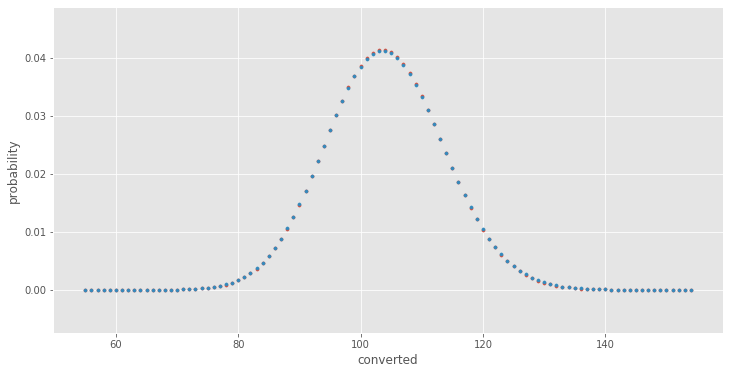

In [18]:
fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(A_converted-49, A_converted+50, 100)
yA = scs.binom(A_total, p_A).pmf(xA)
ax.scatter(xA, yA, s=10)
xB = np.linspace(B_converted-49, B_converted+50, 100)
yB = scs.binom(B_total, p_B).pmf(xB)
ax.scatter(xB, yB, s=10)
plt.xlabel('converted')
plt.ylabel('probability')

We can see that the test group converted more users than the control group. However, the plot above is not a plot of the null and alternate hypothesis. The null hypothesis is a plot of the difference between the probability of the two groups.

In order to calculate the difference between the two groups, we need to standardize the data. Because the number of samples might be different between the two groups, we should compare the probability of successes, p.

Consider the [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution) for the control group.

$$ X \sim Bernoulli(p) $$
where p is the true conversion probability of the control group.

According to the properties of the Bernoulli distribution, the mean and variance are as follows:

$$ E(X) = p $$

$$ Var(X) = p(1-p) $$ 

According to the central limit theorem, by calculating many sample means we can approximate the true mean of the population from which the data for the control group was taken. The distribution of the sample means will be normally distributed around the true mean with a standard deviation equal to the [standard error of the mean](https://en.wikipedia.org/wiki/Standard_error).

The [standard error of the mean](https://en.wikipedia.org/wiki/Standard_error) is given as:

$$ \sigma_{\bar{x}} = \frac{s}{\sqrt{n}} = \frac{\sqrt{p(1-p)}}{\sqrt{n}} $$

The same can be done with the alternate group.

Therefore, we can represent both groups as a normal distribution with the following properties

$$ \hat{p} \sim Normal\left(\mu = p, \: \sigma = \frac{\sqrt{p(1-p)}}{\sqrt{n}}\right) $$

In [19]:
SE_A = np.sqrt(p_A * (1-p_A)) / np.sqrt(A_total)
SE_A

0.010031057096910649

In [20]:
SE_B = np.sqrt(p_B * (1-p_B)) / np.sqrt(B_total)
SE_B

0.009302605094190636

Text(0, 0.5, 'PDF')

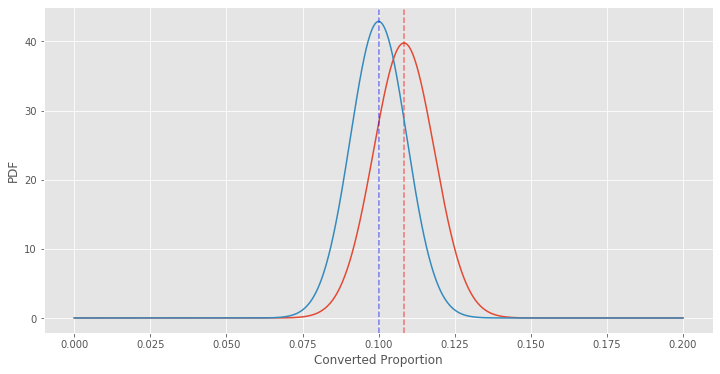

In [21]:
fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(0, .2, 1000)
yA = scs.norm(p_A, SE_A).pdf(xA)
ax.plot(xA, yA)
ax.axvline(x=p_A, c='red', alpha=0.5, linestyle='--')

xB = np.linspace(0, .2, 1000)
yB = scs.norm(p_B, SE_B).pdf(xB)
ax.plot(xB, yB)
ax.axvline(x=p_B, c='blue', alpha=0.5, linestyle='--')

plt.xlabel('Converted Proportion')
plt.ylabel('PDF')

The dashed lines represent the mean conversion rate for each group. The distance between the red dashed line and the blue dashed line is equal to d_hat.

$$ \hat{d} = \hat{p}_B - \hat{p}_A $$

## Back to the Null and Alternate Hypothesis
Recall that the null hypothesis states that the difference in probability between the two groups is zero. We should construct a distribution of this difference, since for any A/B experiment our value for p each come from a two different distributions and the difference will have its own variance.

$$ H_0: d = 0 $$

$$ \hat{d} \sim Normal(0, \: SE_{pool}) $$

$$ H_A: d = p_B - p_A $$

$$ \hat{d} \sim Normal(d, \: SE_{pool}) $$

## Variance of the Sum
The [variance of the sum](https://en.wikipedia.org/wiki/Variance) (of two random independent variables) is the sum of the variances.

$$ Var(X + Y) = Var(X) + Var(Y) $$
$$ Var(X - Y) = Var(X) + Var(Y) $$

Because the distribution for the difference is calculated from two normal distributions, we can assume that the difference will be normally distributed.

The null hypothesis is the normal distribution of the difference with a mean of zero. 

The alternate hypothesis is the normal distribution of the difference with a mean of the difference in the means of the two groups. 

The null hypothesis and alternate hypothesis will the same variance which will be the sum of the variances for the control group and the test group.

$$ Var(\hat{d}) = Var(\hat{p}_B - \hat{p}_A) = Var(\hat{p}_A) + Var(\hat{p}_B) = \frac{p_A(1-p_A)}{n_A} + \frac{p_B(1-p_B)}{n_B} $$

The standard deviation will be the square root of the variance.

$$ \sigma = \sqrt{Var(\hat{d})} = \sqrt{ \frac{p_A(1-p_A)}{n_A} + \frac{p_B(1-p_B)}{n_B} } $$

## Pooled Variance
We can put this equation in terms of $s$, where $s$ is the standard deviation of the Bernoulli distribution.

$$ \sigma = \sqrt{Var(\hat{d})} = \sqrt{ \frac{s_A^2}{n_A} + \frac{s_B^2}{n_B} } $$

The is the [Satterthwaite approximation](http://www.statisticshowto.com/satterthwaite-approximation/) for pooled variance.

If we pool the probability like the [Udacity lesson](https://www.youtube.com/watch?v=iub8yWiO84I) and then calculate the variance for the pooled probability, we would end up with the same equation for pooled variance shown in the lesson.

$$ \sigma = \sqrt{Var(\hat{d})} = \sqrt{ \frac{s_p^2}{n_A} + \frac{s_p^2}{n_B} } = \sqrt{ s_p \left(\frac{1}{n_A} + \frac{1}{n_B} \right) } = \sqrt{ \hat{p}_p(1-\hat{p}_p) \left(\frac{1}{n_A} + \frac{1}{n_B} \right) } $$

$$ \hat{p}_p = \frac{p_A N_A + p_B N_B}{N_A + N_B} $$

### Statistical power
We now need to consider the confidence level of the test. We will plot the null hypothesis and the alternative hypothesis.

* The null hypothesis is that the change made for the test group **would result in no change** in the conversion rate.
* The alternative hypothesis is that the change for the test group **would result in a detectable change** in the conversion rate.

We can represent the null hypothesis by plotting the distribution of the difference between the control and test group. According to the Udacity course, the distribution will be normal with a mean of zero and a standard deviation equal to the pooled standard error. This is an application of the central limit theorem. 

According to statisticshowto:
The Central Limit Theorem states that the sampling distribution of the sample means approaches a normal distribution as the sample size gets larger — no matter what the shape of the population distribution.


We can prove this by the following: 
Our control and test groups are samples taken from a population. 
We are taking the mean of each group's distribution, which in this case is binomial, and we are finding the difference Let's demonstrate if this distribution is truly normal. We can use our data generation script to repeat this process 1000 times. We will set the variable, `d_hat`, to zero to represent the case where the null hypothesis is true.

### 

### Pooled Standard Error

$$ SE_p = \sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}$$ 

$$ SE_p = S_p\sqrt{\frac{1}{n_1} + \frac{1}{n_2}} = \sqrt{S_p^2\left(\frac{1}{n_1} + \frac{1}{n_2} \right)} = \sqrt{ p_p(1-p_p) \left(\frac{1}{n_1} + \frac{1}{n_2} \right)} $$

$$ SE_p = \sqrt{ p_p(1-p_p) \left(\frac{1}{n_1} + \frac{1}{n_2} \right)} $$

In [22]:
bcr = p_A
d_hat = p_B - p_A

In [23]:
N_A, N_B, bcr, d_hat

(1000, 1000, 0.10833333333333334, -0.008333333333333331)

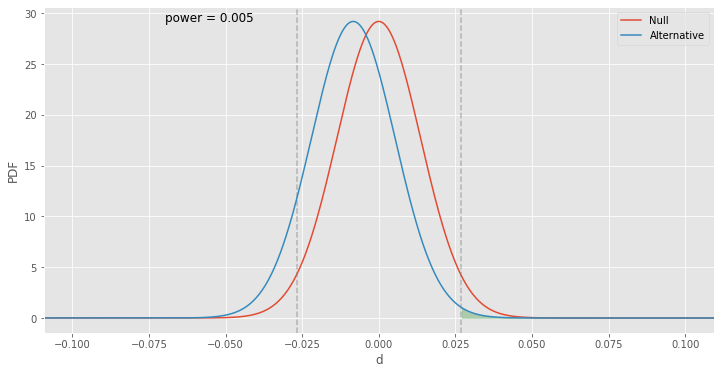

In [24]:
abplot(N_A, N_B, bcr, d_hat, show_power=True)

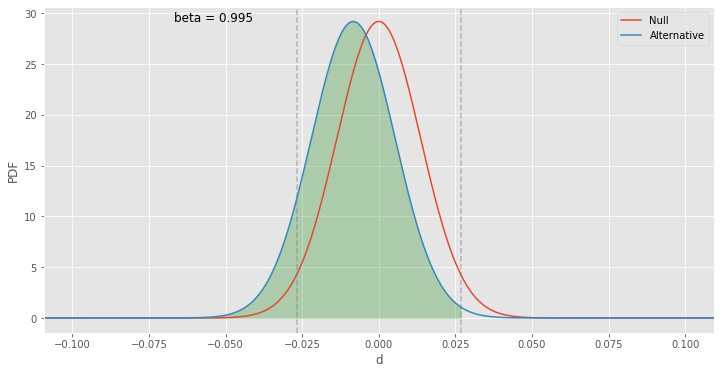

In [25]:
abplot(N_A, N_B, bcr, d_hat, show_beta=True)

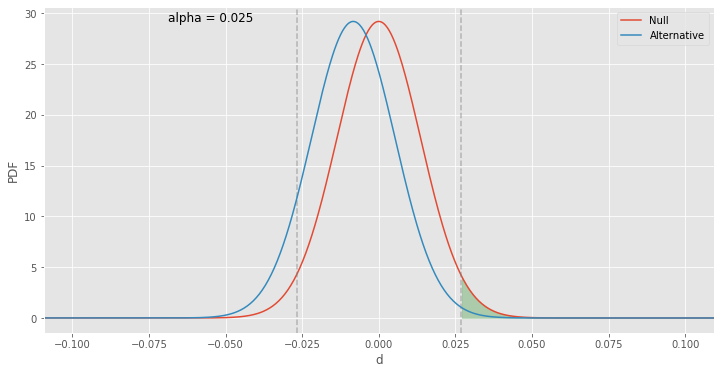

In [26]:
abplot(N_A, N_B, bcr, d_hat, show_alpha=True)

$$ \alpha = 100\% - \text{Confidence Level} $$

In [27]:
bcr, d_hat

(0.10833333333333334, -0.008333333333333331)

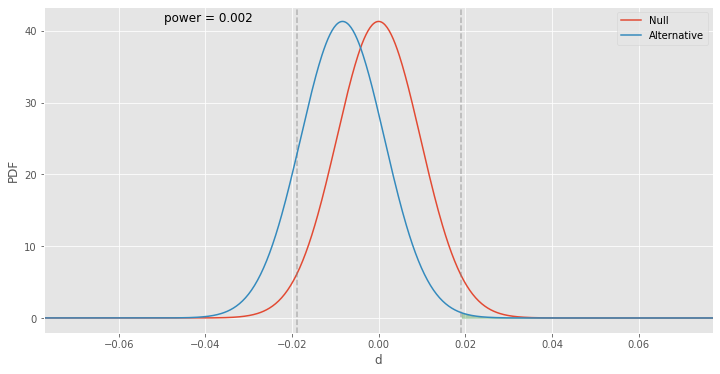

In [28]:
abplot(2000, 2000, bcr, d_hat, show_power=True)

## Calculate the minimum sample size

$$ n = \frac{2(\bar{p})(1-\bar{p})(Z_\beta + Z_{\alpha/2})^2}{(p_B - p_A)^2} $$

$$ Z_\beta : \text{z-score that corresponds to the level of statistical power} $$
$$ Z_{\alpha/2} : \text{z-score that corresponds to the level of significance or confidence level} $$

$$\bar{p}: \text{pooled probability or average of } p_A \text{ and } p_B $$
$$p_A: \text{success rate of control group} $$
$$p_B: \text{success rate of test group} $$

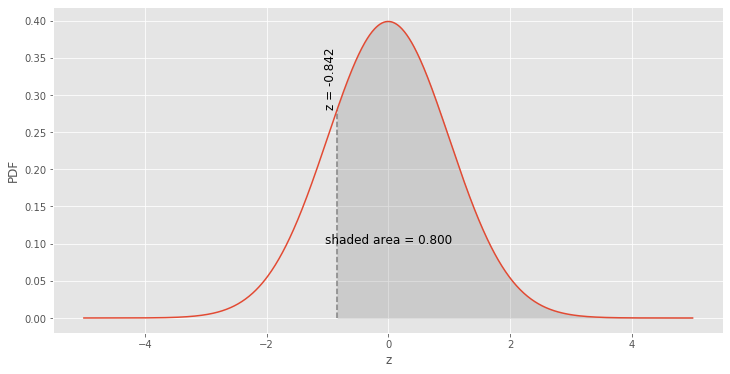

In [29]:
zplot(area=0.80, two_tailed=False, align_right=True)

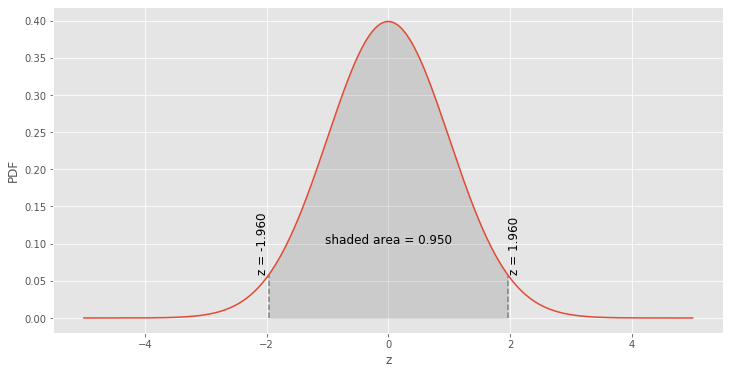

In [30]:
zplot(area=0.95, two_tailed=True)

In [31]:
min_sample_size(bcr=0.10, mde=0.02)

3842.026629963879

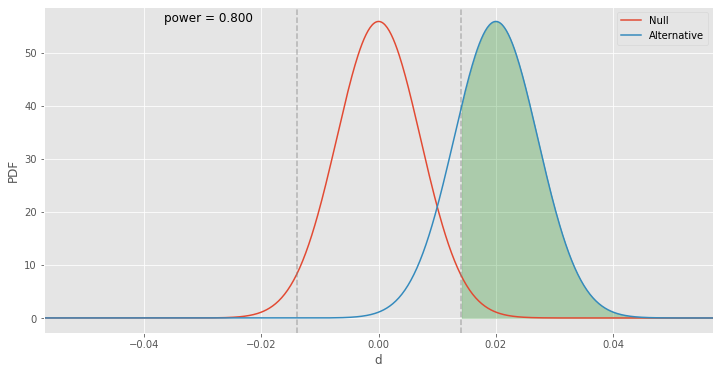

In [32]:
abplot(3843, 3843, 0.10, 0.02, show_power=True)

## Increase the Sample Size

In [33]:
# parameters for generate_data()
N_A = 6000
N_B = 6000
p_A=0.10
p_B=0.12

In [34]:
ab_data = generate_data(N_A, N_B, p_A, p_B)

In [35]:
ab_summary = ab_data.pivot_table(values='converted', index='group', aggfunc=np.sum)
ab_summary['total'] = ab_data.pivot_table(values='converted', index='group', aggfunc=lambda x: len(x))
ab_summary['rate'] = ab_data.pivot_table(values='converted', index='group')

In [36]:
ab_summary

,converted,total,rate
group,,,
A,583,5949,0.098000
B,738,6051,0.121963


In [37]:
# parameters for abplot
n = N_A + N_B
p_A_actual = ab_summary.loc['A', 'rate']
p_B_actual = ab_summary.loc['B', 'rate']
bcr = p_A_actual
d_hat = p_B_actual - p_A_actual

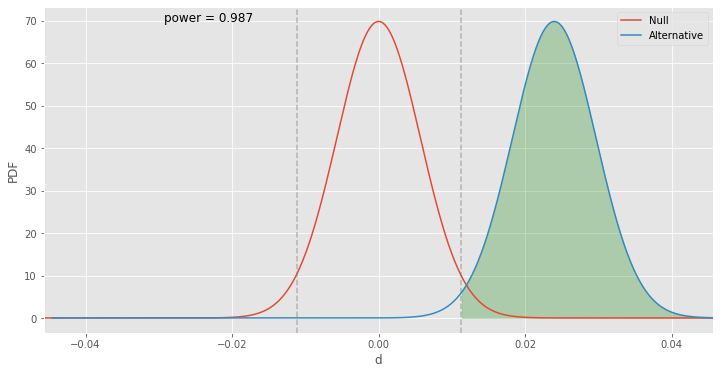

In [38]:
abplot(N_A, N_B, bcr, d_hat, show_power=True)

## Multiple Tests and Funnel Tests

## Confidence Interval Plot

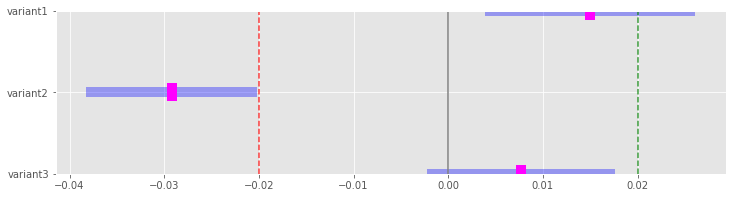

In [39]:
abplot_CI_bars((6000, 6000, 8900, 9100), (600, 690, 630, 980), sig_level=0.05, dmin=0.02)

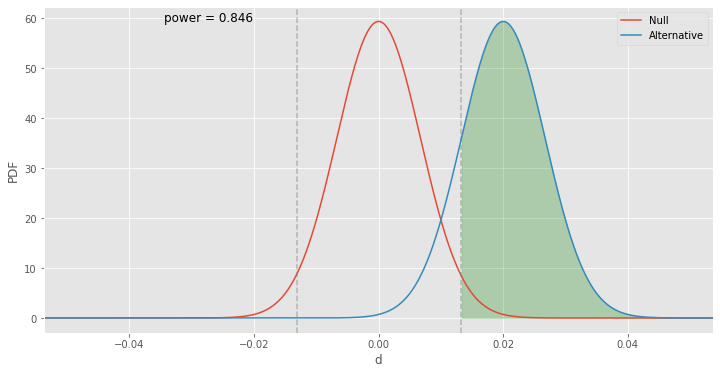

In [40]:
abplot(3000, 9100, 0.10, 0.02, show_power=True)

In [41]:
A = [(10000, 2000), (2000, 200), (300, 40)]
B = [(10000, 2200), (2000, 240), (300, 25)]

[ 0.02  0.02 -0.05]


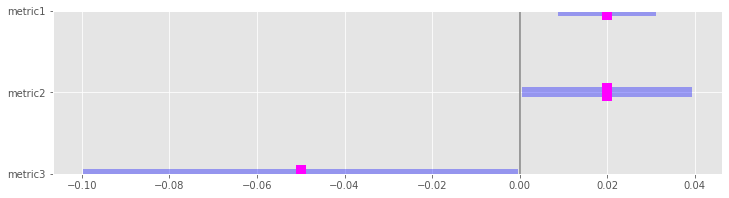

In [42]:
funnel_CI_plot(A, B, sig_level=0.05)